In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
data_complete = pd.read_csv('./super_data.csv')
data = data_complete[data_complete.columns[2:]].drop(['YEAR'], axis=1)
data['PH'] = data['PH'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4566 entries, 0 to 4565
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PH      4559 non-null   float64
 1   EC      4561 non-null   float64
 2   ALK     4559 non-null   float64
 3   SO4     4559 non-null   float64
 4   CO3     4554 non-null   float64
 5   F       4559 non-null   float64
 6   MG      4559 non-null   float64
 7   HCO3    4559 non-null   float64
 8   TDS     4559 non-null   float64
 9   NO3     4559 non-null   float64
 10  TH      4558 non-null   float64
 11  CL      4559 non-null   float64
 12  NA      4558 non-null   float64
 13  CA      4558 non-null   float64
 14  K       4558 non-null   float64
dtypes: float64(15)
memory usage: 535.2 KB


## :sparkles: CCME-WQI

In [4]:
drinking_water_range = {
    # "Component": [Acceptable Limit, Permissible Limit in absence of alternative source]
    "PH": [6.5, 8.5], #
    "EC": [0, 1500], #
    "TDS": [500, 2000], #
    "ALK": [200, 600], #
    "TH": [200, 600], #
    "CL": [250, 1000], #
    "CA": [75, 200], #
    "MG": [30, 100], #
    "SO4": [200, 400], #
    "NO3": [0, 45], #
    "F": [1, 1.5], #
}

In [5]:
import numpy as np

features = drinking_water_range.keys()
total_number_of_features = len(features)

def calculate_F1(df, guideline_values):
    F1 = sum(1 for feature in features if df[feature] < guideline_values[feature][0] or df[feature] > guideline_values[feature][1])
    return (F1*100)/total_number_of_features


def calculate_F2(df, guideline_values):
    F2 = sum(1 for feature in features if df[feature] > guideline_values[feature][1])
    return (F2*100)/total_number_of_features


def calculate_F3(df, guideline_values):
    F3_list = []
    for feature in features:
        F3 = 0
        if df[feature] < guideline_values[feature][0]:
            F3 = (guideline_values[feature][0] - df[feature])/guideline_values[feature][0]
        elif df[feature] > guideline_values[feature][1]:
            F3 = (df[feature] - guideline_values[feature][1])/guideline_values[feature][1]
        F3_list.append(F3)
    nse = sum(F3_list)/len(features)
    return nse/(0.01*nse + 0.01)


def calculate_WQI(df, guideline_values):
    wqi_values = []
    for idx, row in df.iterrows():
        F1 = calculate_F1(df.iloc[idx], guideline_values)
        F2 = calculate_F2(df.iloc[idx], guideline_values)
        F3 = calculate_F3(df.iloc[idx], guideline_values)
        wqi = (np.sqrt(F1*F1 + F2*F2 + F3*F3) / 1.732)  # Dividing by 1.732 to reduce the value to 100
        wqi_values.append(wqi)
    return wqi_values


# Calculating WQI for each instance
wqi_values = calculate_WQI(data, drinking_water_range)
# Adding WQI values to DataFrame
results = pd.DataFrame()
results['CCME-WQI'] = wqi_values
results['CCME-WQI'] = results['CCME-WQI'].apply(lambda x: np.abs(100-x))

In [6]:
results['CCME-WQI']

0       61.555420
1       64.601738
2       69.023569
3       76.746451
4       29.843938
          ...    
4561    60.989717
4562    57.180425
4563    75.149894
4564    87.842858
4565    77.998531
Name: CCME-WQI, Length: 4566, dtype: float64

## :sparkles: WAWQI

In [7]:
constants = pd.DataFrame({
    'features':        ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG'],
    'standard_values': [8.5 , 300, 1000,  120, 300, 1.5, 250,  45,  250,  75,  30],
    'ideal_values':    [    7,  0,    0,    0,   0,   0,   0,   0,    0,   0,   0],
})

In [8]:
def calculate_K():
    return 1/(constants['standard_values'].sum())

def calculate_qi_wi(df):
    qn = pd.DataFrame()
    qi_wi = []
    Wn = calculate_unit_weight_of_nth_parameter()

    for col in constants['features']:
        v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
        s_value = constants[constants['features'] == col]['standard_values'].values[0]
        qn[col] = 100 * ((df[col] - v_ideal) / (s_value - v_ideal))

    for row in qn.iterrows():
        qi_wi.append((np.array(row[1])*Wn).sum())
    
    qn['qi_wi'] = qi_wi

    return qn

def calculate_unit_weight_of_nth_parameter():
    Wn = []
    K = calculate_K()
    for feature in features:
        Wn.append(K/constants[constants['features'] == feature]['standard_values'])
    constants['unit_weights'] = Wn
    return Wn

def calculate_wawqi(data):
    Wn = calculate_unit_weight_of_nth_parameter()
    qn = calculate_qi_wi(data)

    wawqi = qn['qi_wi'] / np.array(Wn).sum()
    return wawqi/100

wawqi = calculate_wawqi(data)

In [9]:
results['WAWQI'] = wawqi

In [10]:
results

,CCME-WQI,WAWQI
0,61.555420,38.644111
1,64.601738,8.988333
2,69.023569,22.555222
3,76.746451,14.035111
4,29.843938,103.398000
...,...,...
4561,60.989717,7.274778
4562,57.180425,34.582556
4563,75.149894,23.527667
4564,87.842858,15.582556


## :sparkles: EBWQI

In [11]:
from sklearn.preprocessing import MinMaxScaler

# data = data.drop(['DISTRICT','YEAR','LOCATION'], axis=1).reset_index(drop=True)
data = data.reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data

,PH,EC,ALK,SO4,CO3,F,MG,HCO3,TDS,NO3,TH,CL,NA,CA,K
0,0.008383,0.088537,0.441708,0.122183,0.0,0.040625,0.012223,0.467816,0.087319,0.010625,0.051877,0.031796,0.125323,0.019608,0.000667
1,0.008221,0.014630,0.109195,0.029656,0.0,0.027500,0.002546,0.120295,0.013312,0.007500,0.017084,0.001481,0.016989,0.010893,0.028667
2,0.008647,0.047222,0.252874,0.019375,0.0,0.003125,0.018335,0.270489,0.045970,0.010000,0.064055,0.018675,0.050966,0.013072,0.061667
3,0.008521,0.027630,0.137931,0.021352,0.0,0.021875,0.007894,0.150193,0.026348,0.010625,0.036220,0.007569,0.025606,0.015251,0.008667
4,0.008434,0.268889,0.404762,0.189008,0.0,0.038750,0.055004,0.429124,0.267907,0.028125,0.234543,0.179096,0.361689,0.095861,0.055000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,0.008045,0.014222,0.051724,0.043100,0.0,0.001875,0.004838,0.060148,0.012925,0.002000,0.031001,0.004360,0.011449,0.019608,0.016667
4562,0.008434,0.081833,0.125616,0.137999,0.0,0.009750,0.028520,0.137531,0.080621,0.008125,0.121638,0.043478,0.087406,0.050109,0.028333
4563,0.008271,0.054481,0.084565,0.228153,0.0,0.011625,0.004329,0.094618,0.053222,0.020625,0.069274,0.023035,0.067709,0.069717,0.043333
4564,0.007957,0.027111,0.195402,0.025306,0.0,0.013000,0.009167,0.210341,0.025822,0.000194,0.071014,0.005553,0.015142,0.054466,0.030000


In [12]:
import numpy as np

# calculate entropy weight and information entropy for entropy water quality index
def information_entropy(df):
    # calculate information entropy
    information_entropy_arr = {}
    for i in range(len(df.columns)):
        p = df.iloc[:,i]/df.iloc[:,i].sum()
        entropy = - (p * np.log(p)/np.log(len(df))).sum()
        information_entropy_arr[df.columns.to_list()[i]] = entropy
    return information_entropy_arr

def entropy_weight(df):
    # calculate entropy weight
    information_entropy_arr_res = information_entropy(df)
    information_entropy_arr = np.array(list(information_entropy_arr_res.values()))
    # print(information_entropy_arr_res)
    information_entropy_arr_sum = np.sum(1 - information_entropy_arr)
    information_entropy_arr_res_df = pd.DataFrame({
        'features': list(information_entropy_arr_res.keys()),
        'information_entropy': list(information_entropy_arr_res.values())
    })
    # print(information_entropy_arr_res_df)
    information_entropy_arr_res_df['entropy_weights'] = (1 - information_entropy_arr_res_df['information_entropy'])/information_entropy_arr_sum
    # print(information_entropy_arr_res_df)
    return information_entropy_arr_res_df

entropy_weight_arr = entropy_weight(scaled_data[constants['features']])
entropy_weight_arr

,features,information_entropy,entropy_weights
0,PH,0.988699,0.020064
1,EC,0.950484,0.087912
2,TDS,0.947134,0.093858
3,ALK,0.980946,0.033829
4,TH,0.958217,0.074182
5,F,0.942822,0.101516
6,CL,0.899062,0.179207
7,NO3,0.922581,0.137451
8,SO4,0.953831,0.081969
9,CA,0.952911,0.083603


In [13]:
constants['weights'] = entropy_weight_arr['entropy_weights'].to_list()
constants

,features,standard_values,ideal_values,unit_weights,weights
0,PH,8.5,7,"0 0.000049 Name: standard_values, dtype: fl...",0.020064
1,EC,300.0,0,"1 0.000001 Name: standard_values, dtype: fl...",0.087912
2,TDS,1000.0,0,"2 4.201681e-07 Name: standard_values, dtype...",0.093858
3,ALK,120.0,0,"3 0.000004 Name: standard_values, dtype: fl...",0.033829
4,TH,300.0,0,"4 0.000001 Name: standard_values, dtype: fl...",0.074182
5,F,1.5,0,"6 0.000002 Name: standard_values, dtype: fl...",0.101516
6,CL,250.0,0,"9 0.000006 Name: standard_values, dtype: fl...",0.179207
7,NO3,45.0,0,"10 0.000014 Name: standard_values, dtype: f...",0.137451
8,SO4,250.0,0,"8 0.000002 Name: standard_values, dtype: fl...",0.081969
9,CA,75.0,0,"7 0.000009 Name: standard_values, dtype: fl...",0.083603


In [14]:
import numpy as np

qe = pd.DataFrame()
qi_wi = []

for col in constants['features']:
    # print('col = ', col)
    v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
    s_value = constants[constants['features'] == col]['standard_values'].values[0]
    # print(v_ideal, s_value)
    qe[col] = 100 * (data[col] - v_ideal) / (s_value - v_ideal)

for row in qe.iterrows():
    qi_wi.append((np.array(row[1])*constants['weights']).sum())

qe

,PH,EC,TDS,ALK,TH,F,CL,NO3,SO4,CA,MG
0,46.000000,1593.666667,320.3,916.666667,100.000000,216.666667,312.0,37.777778,108.0,53.333333,160.000000
1,37.333333,263.333333,52.9,241.666667,33.333333,146.666667,17.2,26.666667,14.4,32.000000,33.333333
2,60.000000,850.000000,170.9,533.333333,123.333333,16.666667,184.4,35.555556,4.0,37.333333,240.000000
3,53.333333,497.333333,100.0,300.000000,70.000000,116.666667,76.4,37.777778,6.0,42.666667,103.333333
4,48.666667,4840.000000,972.8,841.666667,450.000000,206.666667,1744.4,100.000000,175.6,240.000000,720.000000
...,...,...,...,...,...,...,...,...,...,...,...
4561,28.000000,256.000000,51.5,125.000000,60.000000,10.000000,45.2,7.111111,28.0,53.333333,63.333333
4562,48.666667,1473.000000,296.1,275.000000,233.666667,52.000000,425.6,28.888889,124.0,128.000000,373.333333
4563,40.000000,980.666667,197.1,191.666667,133.333333,62.000000,226.8,73.333333,215.2,176.000000,56.666667
4564,23.333333,488.000000,98.1,416.666667,136.666667,69.333333,56.8,0.688889,10.0,138.666667,120.000000


In [15]:
qe['qi_wi'] = qi_wi
results['EBWQI'] = qe['qi_wi'] / constants['weights'].sum()
results

,CCME-WQI,WAWQI,EBWQI
0,61.555420,38.644111,322.953062
1,64.601738,8.988333,68.551642
2,69.023569,22.555222,187.772599
3,76.746451,14.035111,115.300810
4,29.843938,103.398000,1038.036172
...,...,...,...
4561,60.989717,7.274778,60.166415
4562,57.180425,34.582556,331.010335
4563,75.149894,23.527667,217.290519
4564,87.842858,15.582556,119.304083


(0.0, 1000.0)

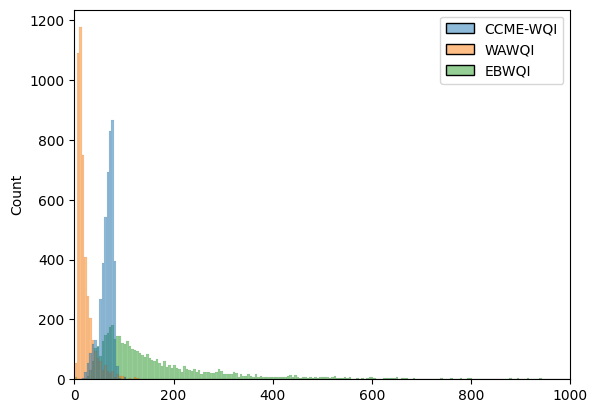

In [16]:
sns.histplot(results)
sns.set_palette('Pastel2')
plt.xlim(0, 1000)

In [17]:
results.to_csv("wqi_results.csv", index=False)

## Regression

In [18]:
# import all other regression models available in different libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# import metrics to evaluate the models
from sklearn.model_selection import cross_val_score, KFold

In [19]:
# create a dictionary for model names and model objects

models = {
    'Linear Regression': [LinearRegression(), LinearRegression(), LinearRegression()],
    'Ridge': [Ridge(), Ridge(), Ridge()],
    'Lasso': [Lasso(), Lasso(), Lasso()],
    'Elastic Net': [ElasticNet(), ElasticNet(), ElasticNet()],
    'K Nearest Neighbors': [KNeighborsRegressor(), KNeighborsRegressor(), KNeighborsRegressor()],
    'Decision Tree': [DecisionTreeRegressor(), DecisionTreeRegressor(), DecisionTreeRegressor()],
    'Support Vector Machine': [SVR(), SVR(), SVR()],
    'Ada Boost': [AdaBoostRegressor(), AdaBoostRegressor(), AdaBoostRegressor()],
    'Gradient Boosting': [GradientBoostingRegressor(), GradientBoostingRegressor(), GradientBoostingRegressor()],
    'Extra Trees': [ExtraTreesRegressor(), ExtraTreesRegressor(), ExtraTreesRegressor()],
    'Random Forest': [RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()],
    'Gaussian Process': [GaussianProcessRegressor(), GaussianProcessRegressor(), GaussianProcessRegressor()],
    'Kernel Ridge': [KernelRidge(), KernelRidge(), KernelRidge()],
    'XGBoost': [XGBRegressor(), XGBRegressor(), XGBRegressor()],
    'CatBoost': [CatBoostRegressor(verbose=False), CatBoostRegressor(verbose=False), CatBoostRegressor(verbose=False)],
    'LightGBM': [LGBMRegressor(), LGBMRegressor(), LGBMRegressor()],
    'Multi Layer Perceptron': [MLPRegressor(), MLPRegressor(), MLPRegressor()]
}

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def correlation_coefficient(observed, predicted):
    return np.corrcoef(observed, predicted)[0, 1]

def root_mean_square_error(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

def nash_sutcliffe_efficiency(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    return 1 - (numerator / denominator)

def index_of_agreement(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((np.abs(predicted - mean_observed) +
                          np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)

In [21]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

k_folds = 5
kf = KFold(n_splits=k_folds)

wqi = pd.concat([data, results], axis=1)
wqi = wqi.dropna()
features = ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG']

X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

# Create a dictionary to store results
results_dict = {'Model': [], 'Model_Ref': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'y_test': [], 'y_pred': []}

# Metrics to calculate
metrics = {
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'R2': r2_score,
    'NSE': lambda y_true, y_pred: 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
}

# Loop through models
for name, model in tqdm(models.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            metric_values = []
            for train_index, val_index in kf.split(target_train):
                if (target_name == "WAWQI"): model_t = model[0]
                elif (target_name == "EBWQI"): model_t = model[1]
                else: model_t = model[2]

                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = target_train.iloc[train_index], target_train.iloc[val_index]

                # Train the model
                model_t.fit(X_train_fold, y_train_fold)

                # Predict on the validation set
                y_val_pred = model_t.predict(X_val_fold)

                # Calculate the metric value for this fold
                fold_metric_value = metric_func(y_val_fold, y_val_pred)
                metric_values.append(fold_metric_value)

            # Average the metric values across folds
            average_metric_value = sum(metric_values) / len(metric_values)

            # Train the model on the entire training set
            model_t.fit(X_train, target_train)

            # Predict on the test set
            y_pred = model_t.predict(X_test)

            # Calculate the metric value on the test set
            test_metric_value = metric_func(target_test, y_pred)

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Model_Ref'].append(model_t)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(test_metric_value)
            results_dict['y_test'].append(target_test)
            results_dict['y_pred'].append(y_pred)

# Create a DataFrame
regression_results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame
comparison_df_reg = regression_results_df.pivot(index='Target', columns=['Metric','Model'], values='Metric Value')

# Print the comparison DataFrame
comparison_df_reg.style.background_gradient(cmap='Greens', axis=None)

  0%|          | 0/17 [00:00<?, ?it/s]

 88%|████████▊ | 15/17 [24:55<05:40, 170.38s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2299
[LightGBM] [Info] Number of data points in the train set: 2912, number of used features: 11
[LightGBM] [Info] Start training from score 20.931115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 2912, number of used features: 11
[LightGBM] [Info] Start training from score 20.696594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 2912, number of used features: 11
[LightGBM] [Info] Start trai

 94%|█████████▍| 16/17 [25:03<02:01, 121.43s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 2912, number of used features: 11
[LightGBM] [Info] Start training from score 65.510085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2408
[LightGBM] [Info] Number of data points in the train set: 3640, number of used features: 11
[LightGBM] [Info] Start training from score 65.422774


100%|██████████| 17/17 [29:11<00:00, 103.02s/it]


Metric,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE
Model,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Ridge,Ridge,Ridge,Ridge,Ridge,Lasso,Lasso,Lasso,Lasso,Lasso,Elastic Net,Elastic Net,Elastic Net,Elastic Net,Elastic Net,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Random Forest,Random Forest,Random Forest,Random Forest,Random Forest,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,XGBoost,XGBoost,XGBoost,XGBoost,XGBoost,CatBoost,CatBoost,CatBoost,CatBoost,CatBoost,LightGBM,LightGBM,LightGBM,LightGBM,LightGBM,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron
Target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCME-WQI,94.778842,9.735443,8.012470,0.471251,0.471251,94.437500,9.717896,7.994938,0.473155,0.473155,98.822613,9.940956,8.320894,0.448692,0.448692,98.468554,9.923132,8.323504,0.450667,0.450667,22.789966,4.773884,3.381878,0.872860,0.872860,16.122659,4.205870,2.243871,0.911717,0.915065,29.566027,5.437465,4.044078,0.835058,0.835058,21.394938,4.417638,3.887490,0.880397,0.884184,2.957229,1.724421,1.212790,0.983451,0.983468,11.883201,3.414661,2.320937,0.935364,0.934438,8.337577,2.894429,1.753880,0.952668,0.954025,141910.329665,376.709875,166.698176,-790.684306,-790.684306,4488.089258,66.993203,66.246029,-24.037993,-24.037993,2.860847,1.691404,0.968074,0.984040,0.984040,0.750227,0.866156,0.507994,0.995815,0.995815,2.100659,1.449365,0.875092,0.988281,0.988281,31.093677,5.436653,4.276483,0.824470,0.837177
EBWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.534017,0.730764,0.046282,0.999987,0.999987,13.345330,3.653126,1.753095,0.999678,0.999678,465.571677,21.577110,12.046178,0.988754,0.988754,1009.524206,31.773011,13.111890,0.975614,0.975614,749.445748,26.063211,12.071443,0.981356,0.983338,22506.534041,150.021779,39.338873,0.456326,0.456326,3368.428713,57.014470,49.429959,0.906741,0.909511,237.695271,15.374095,5.779245,0.994234,0.994179,401.911783,18.627048,6.545177,0.990864,0.990853,551.761326,24.265226,7.796424,0.986073,0.986819,36371.202105,190.712354,44.104691,0.121407,0.121407,35528.506747,188.490071,188.374667,0.141764,0.141764,347.493834,18.641186,6.643180,0.991606,0.991606,277.312738,16.652710,4.055806,0.993301,0.993301,1387.444417,37.248415,8.998455,0.966485,0.966485,36.629091,5.931970,4.725444,0.999443,0.999388
WAWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.006897,0.083049,0.006232,0.999982,0.999982,2.996738,1.731109,1.170718,0.992164,0.992164,5.780090,2.404182,1.529630,0.984887,0.984887,9.166602,3.027640,1.254902,0.976032,0.976032,9.720055,3.035536,1.397086,0.974476,0.972573,117.089318,10.820782,1.898468,0.693847,0.693847,33.621794,5.518389,4.911162,0.927043,0.922712,2.655702,1.654530,0.718055,0.992802,0.992985,4.004699,1.873996,0.767185,0.990763,0.990388,5.963170,2.359757,0.910932,0.985574,0.986256,350.634969,18.725249,4.418768,0.083195,0.083195,436.408337,20.890389,20.877568,-0.141076,-0.141076,2.614540,1.616954,0.641527,0.993164,0.993164,2.301330,1.517013,0.398921,0.993983,0.993983,14.518439,3.810307,1.033548,0.962039,0.962039,0.050047,0.2161

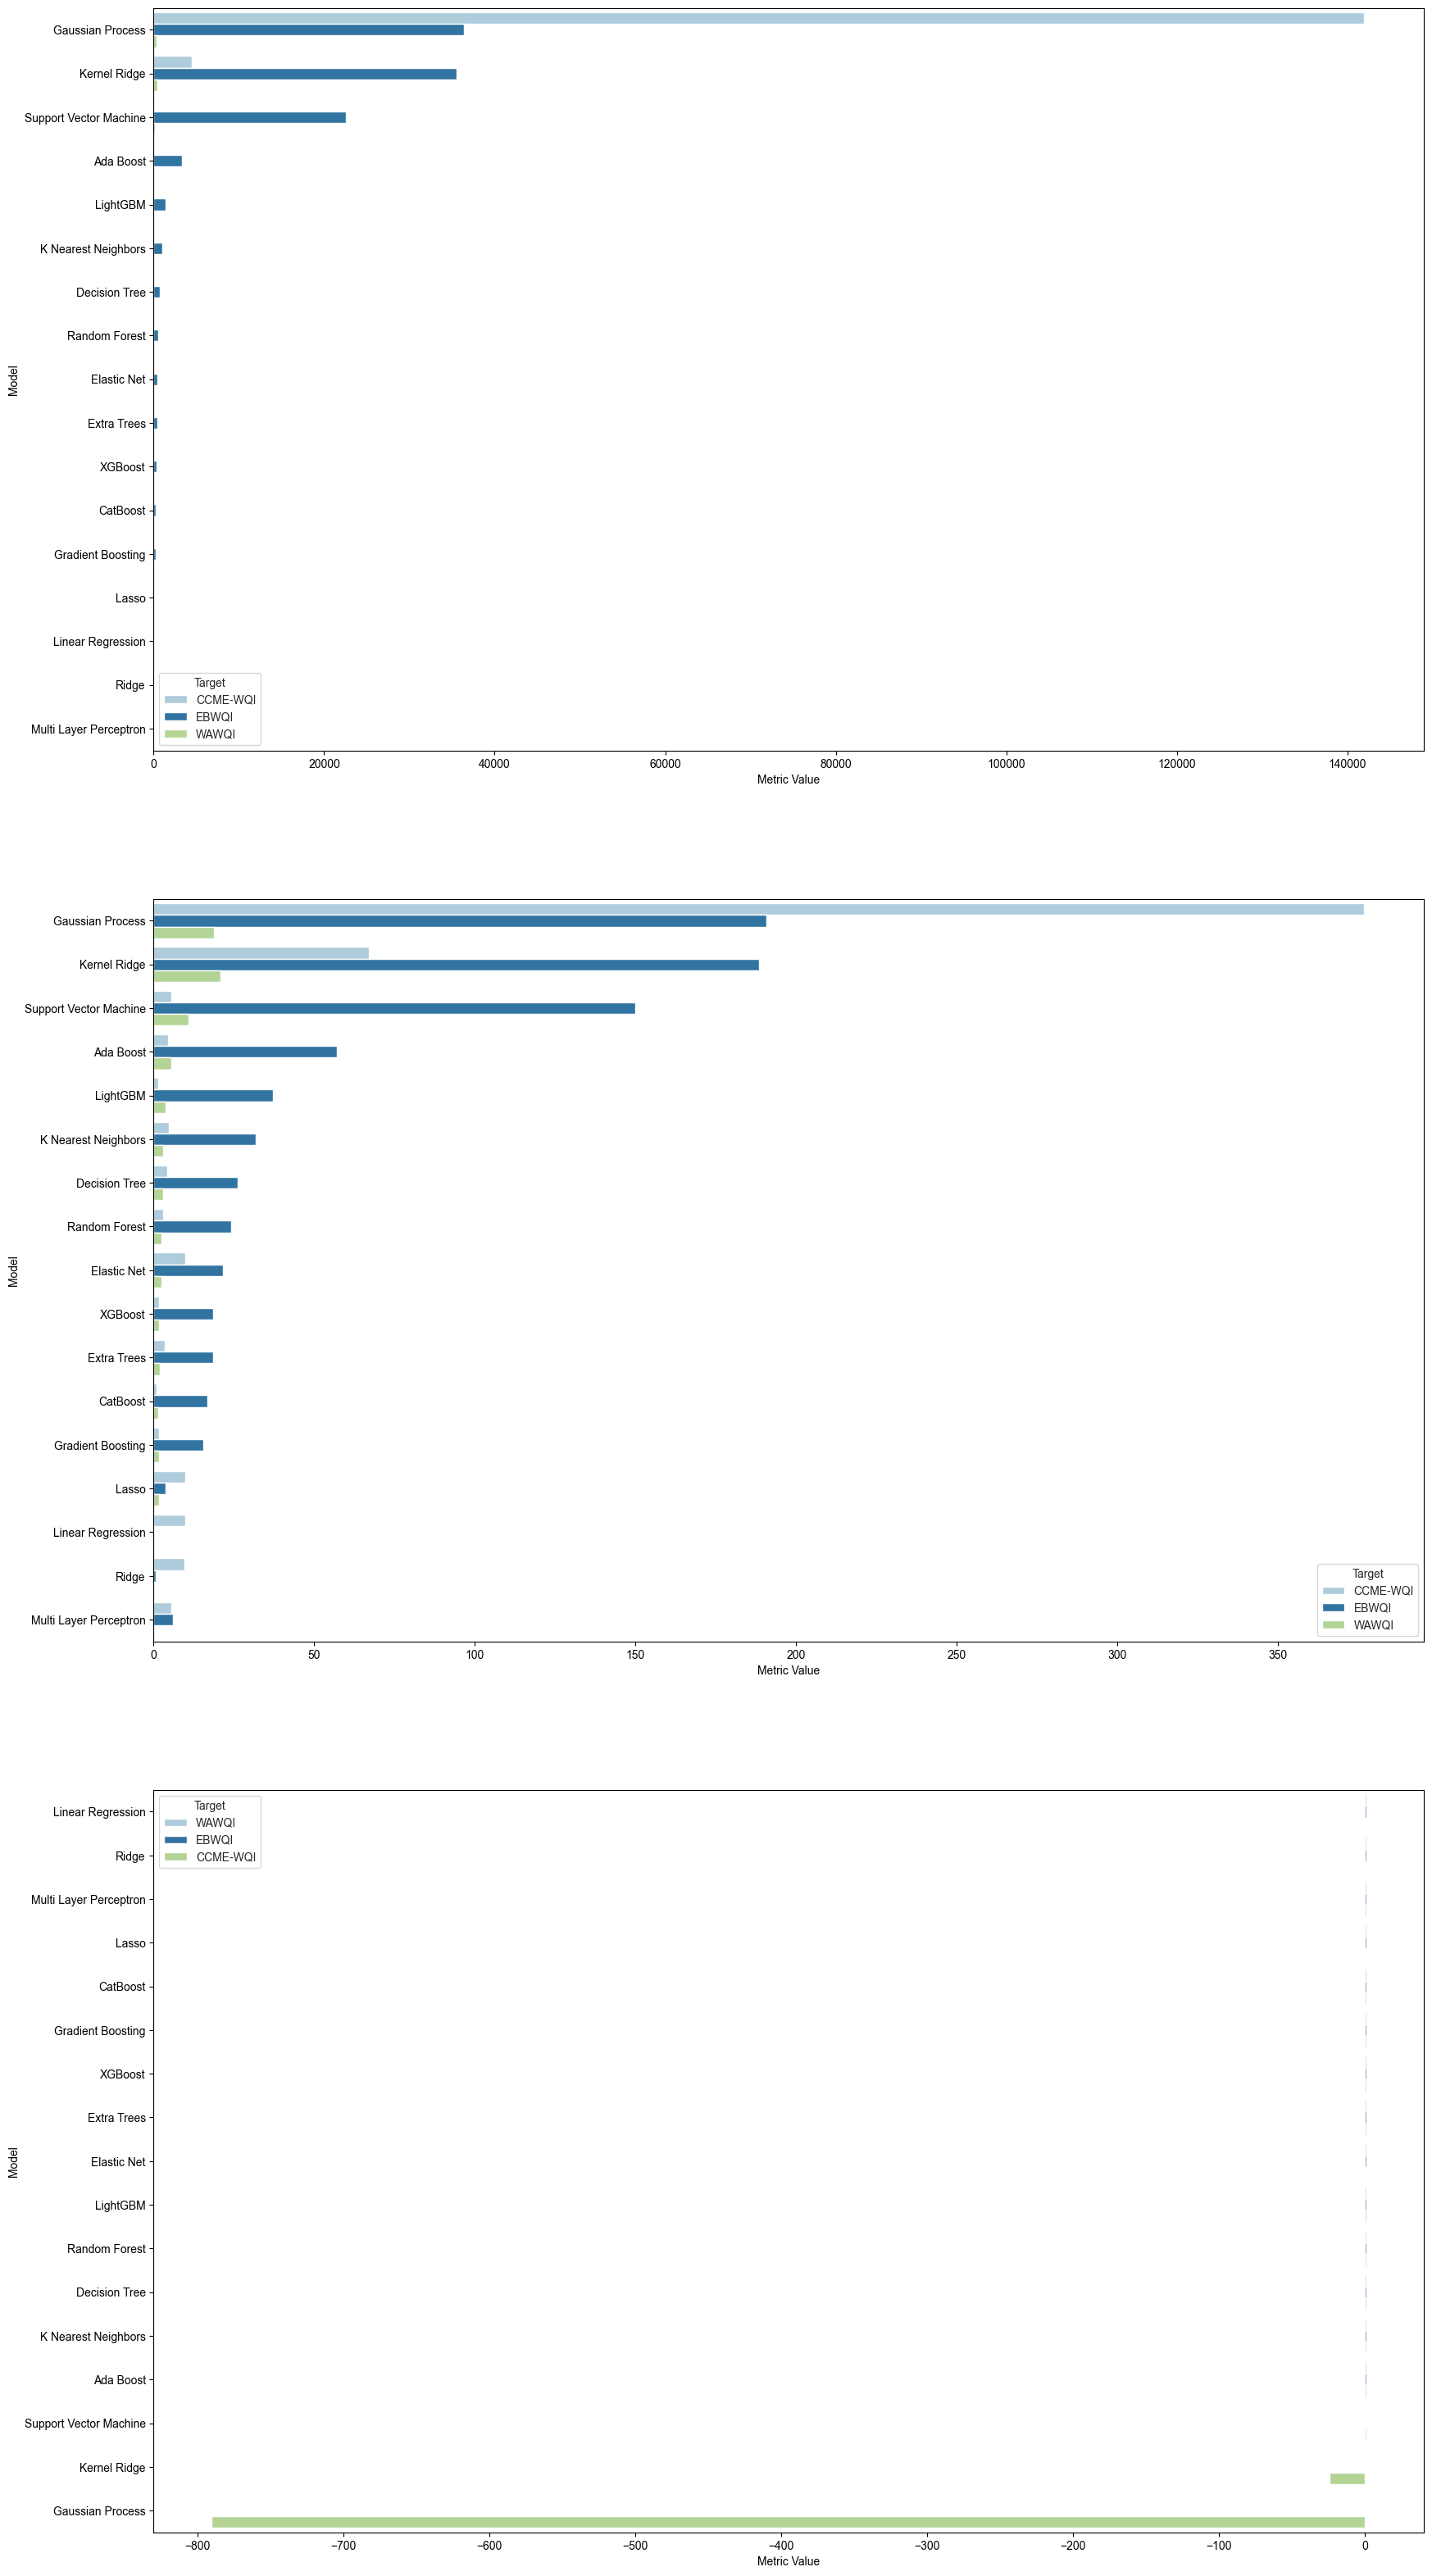

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
sns.set_style('whitegrid')
sns.set_palette('Paired')
for ax, metric in zip(axes.flatten(), ['MSE','RMSE','R2']):
    sns.barplot(data=regression_results_df[regression_results_df['Metric'] == metric].sort_values(by="Metric Value", ascending=False), x='Metric Value', y='Model', hue='Target', ax=ax, orient='h', palette='Paired')

In [23]:
regression_results_df[regression_results_df['Metric'] == 'R2'].sort_values(by='Metric Value', ascending=False).head(10)

,Model,Model_Ref,Target,Metric,Metric Value,y_test,y_pred
3,Linear Regression,LinearRegression(),WAWQI,R2,1.000000,472 53.659444 2531 18.042417 23 12...,"[53.65944444444441, 18.04241666666667, 12.5118..."
8,Linear Regression,LinearRegression(),EBWQI,R2,1.000000,472 537.320129 2531 163.885568 23 ...,"[537.3201289016929, 163.88556808494437, 101.60..."
23,Ridge,Ridge(),EBWQI,R2,0.999987,472 537.320129 2531 163.885568 23 ...,"[537.2795404009294, 163.90318689684247, 101.60..."
18,Ridge,Ridge(),WAWQI,R2,0.999982,472 53.659444 2531 18.042417 23 12...,"[53.65348435667849, 18.040929810696777, 12.512..."
243,Multi Layer Perceptron,MLPRegressor(),WAWQI,R2,0.999859,472 53.659444 2531 18.042417 23 12...,"[53.48210097636259, 18.39384311585859, 12.4995..."
38,Lasso,Lasso(),EBWQI,R2,0.999678,472 537.320129 2531 163.885568 23 ...,"[536.0696690356424, 164.98173151635083, 102.08..."
248,Multi Layer Perceptron,MLPRegressor(),EBWQI,R2,0.999443,472 537.320129 2531 163.885568 23 ...,"[529.9399939788531, 173.82562072677575, 96.731..."
223,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,CCME-WQI,R2,0.995815,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
128,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,EBWQI,R2,0.994234,472 537.320129 2531 163.885568 23 ...,"[525.8887356440378, 168.32914036140653, 97.446..."
213,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,WAWQI,R2,0.993983,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."


In [24]:
regression_results_df[regression_results_df['Metric'] == 'MSE'].sort_values(by='Metric Value', ascending=True).head(10)

,Model,Model_Ref,Target,Metric,Metric Value,y_test,y_pred
0,Linear Regression,LinearRegression(),WAWQI,MSE,5.096997e-28,472 53.659444 2531 18.042417 23 12...,"[53.65944444444441, 18.04241666666667, 12.5118..."
5,Linear Regression,LinearRegression(),EBWQI,MSE,4.045151e-27,472 537.320129 2531 163.885568 23 ...,"[537.3201289016929, 163.88556808494437, 101.60..."
15,Ridge,Ridge(),WAWQI,MSE,6.897113e-03,472 53.659444 2531 18.042417 23 12...,"[53.65348435667849, 18.040929810696777, 12.512..."
240,Multi Layer Perceptron,MLPRegressor(),WAWQI,MSE,5.004664e-02,472 53.659444 2531 18.042417 23 12...,"[53.4398745439435, 18.347248393881543, 12.4895..."
20,Ridge,Ridge(),EBWQI,MSE,5.340165e-01,472 537.320129 2531 163.885568 23 ...,"[537.2795404009294, 163.90318689684247, 101.60..."
220,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,CCME-WQI,MSE,7.502265e-01,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
235,LightGBM,LGBMRegressor(),CCME-WQI,MSE,2.100659e+00,472 35.659063 2531 58.579592 23 71...,"[36.3592714659094, 60.42678405989161, 70.66235..."
210,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,WAWQI,MSE,2.301330e+00,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."
195,XGBoost,"XGBRegressor(base_score=None, booster=None, ca...",WAWQI,MSE,2.614540e+00,472 53.659444 2531 18.042417 23 12...,"[52.575027, 17.17377, 12.535095, 18.138336, 15..."
120,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,WAWQI,MSE,2.655702e+00,472 53.659444 2531 18.042417 23 12...,"[53.2382018414543, 18.594366615333534, 12.1281..."


### Regression Results

In [25]:
regression_df = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost','LightGBM','Random Forest']) ) & (regression_results_df['Metric'] == 'R2')][['Model','Target','Metric','Metric Value']].pivot(index='Model', columns='Target', values='Metric Value')
# create a mean column
regression_df['Mean'] = regression_df.mean(axis=1)
# sort the DataFrame by the mean column
regression_df = regression_df.sort_values(by='Mean', ascending=False)
regression_df.style.background_gradient(cmap='Greens', axis=None)

Target,CCME-WQI,EBWQI,WAWQI,Mean
Model,,,,
CatBoost,0.995815,0.993301,0.993983,0.994366
XGBoost,0.984040,0.991606,0.993164,0.989603
Random Forest,0.952668,0.986073,0.985574,0.974772
LightGBM,0.988281,0.966485,0.962039,0.972268
Linear Regression,0.471251,1.000000,1.000000,0.823750


In [26]:
regression_df = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost','LightGBM','Random Forest']) ) & (regression_results_df['Metric'] == 'R2')][['Model','Target','Metric','Metric Value']].pivot(index='Model', columns='Target', values='Metric Value')
# create a mean column
regression_df['Mean'] = regression_df.mean(axis=1)
# sort the DataFrame by the mean column
regression_df = regression_df.sort_values(by='Mean', ascending=False)
regression_df.style.background_gradient(cmap='Greens', axis=None)

Target,CCME-WQI,EBWQI,WAWQI,Mean
Model,,,,
CatBoost,0.995815,0.993301,0.993983,0.994366
XGBoost,0.984040,0.991606,0.993164,0.989603
Random Forest,0.952668,0.986073,0.985574,0.974772
LightGBM,0.988281,0.966485,0.962039,0.972268
Linear Regression,0.471251,1.000000,1.000000,0.823750


### CatBoost, XGBoost and RandomForest are the best Models

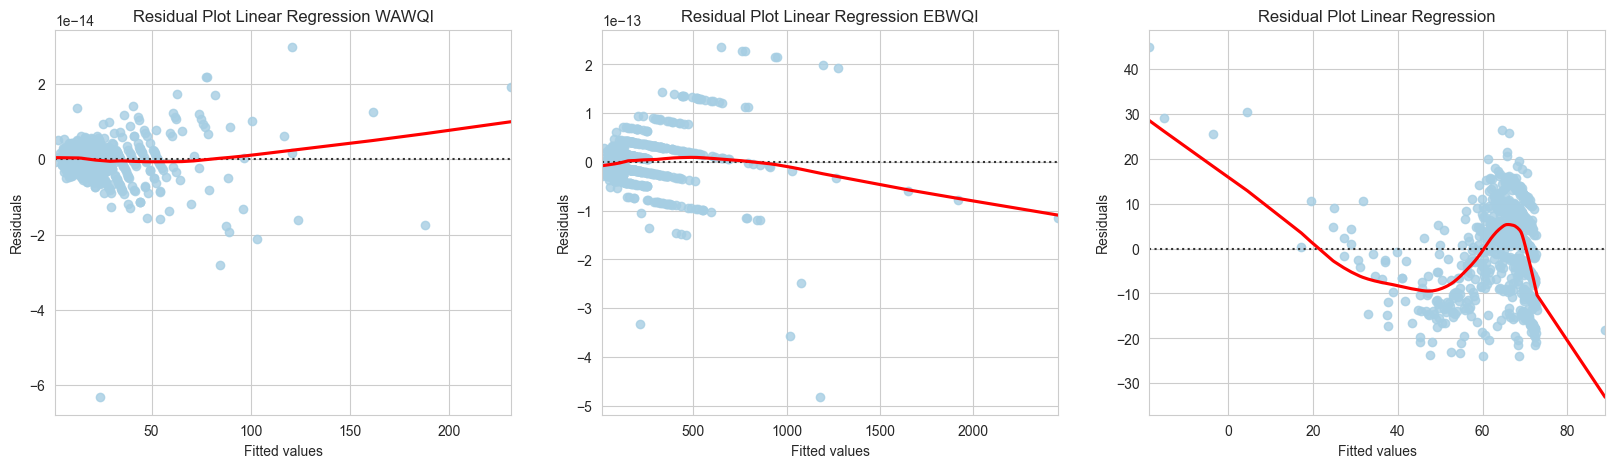

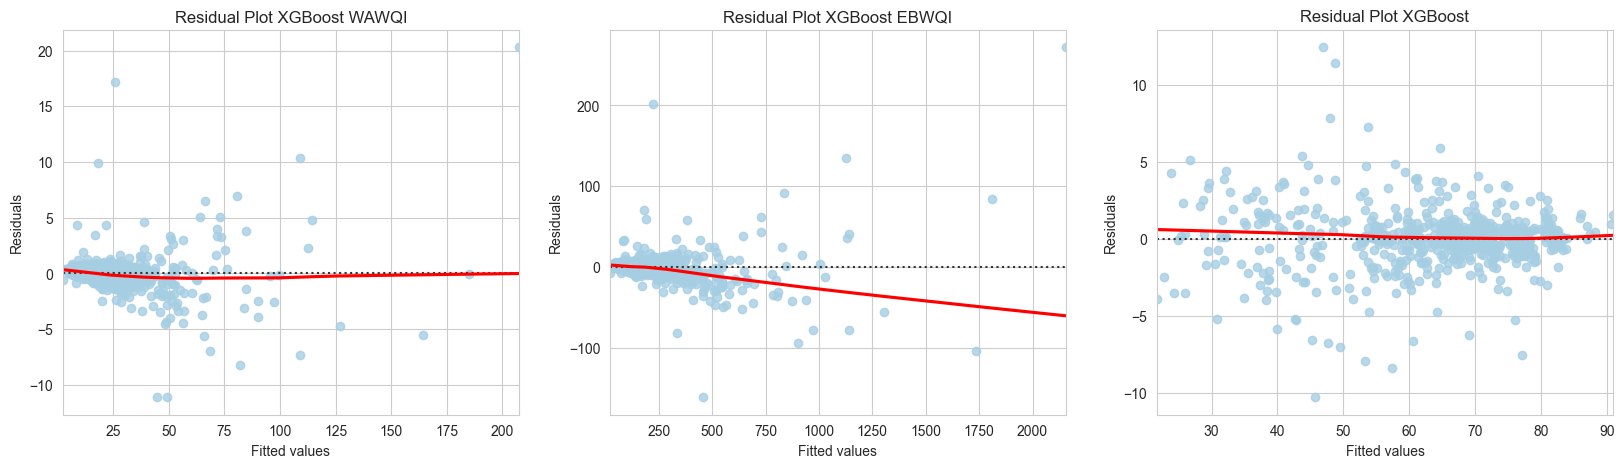

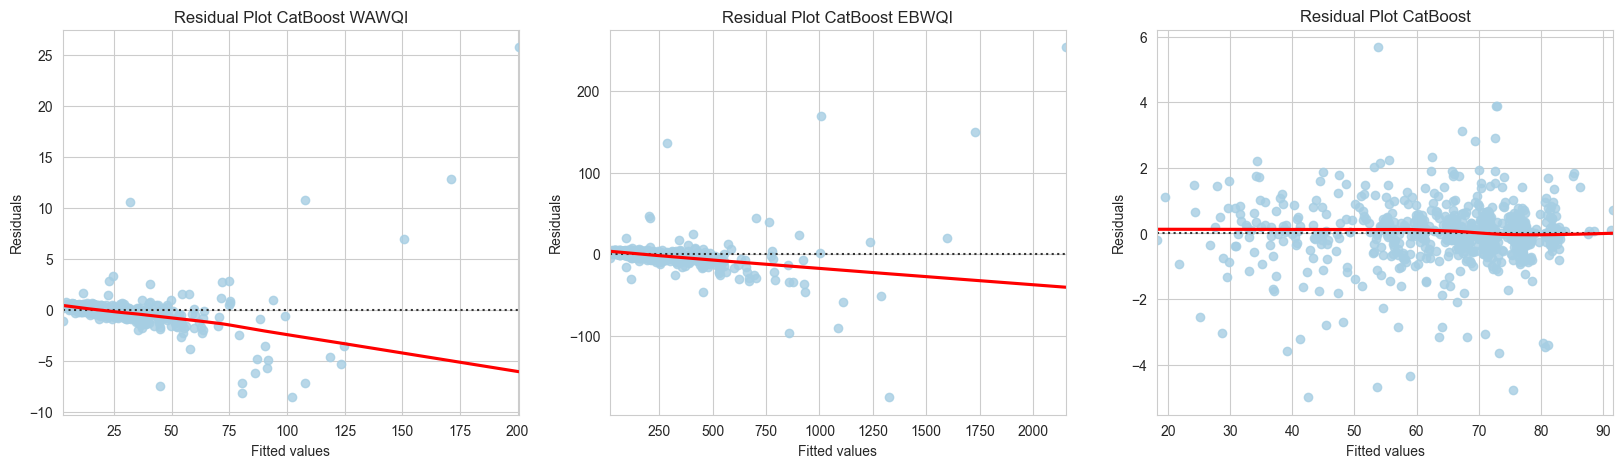

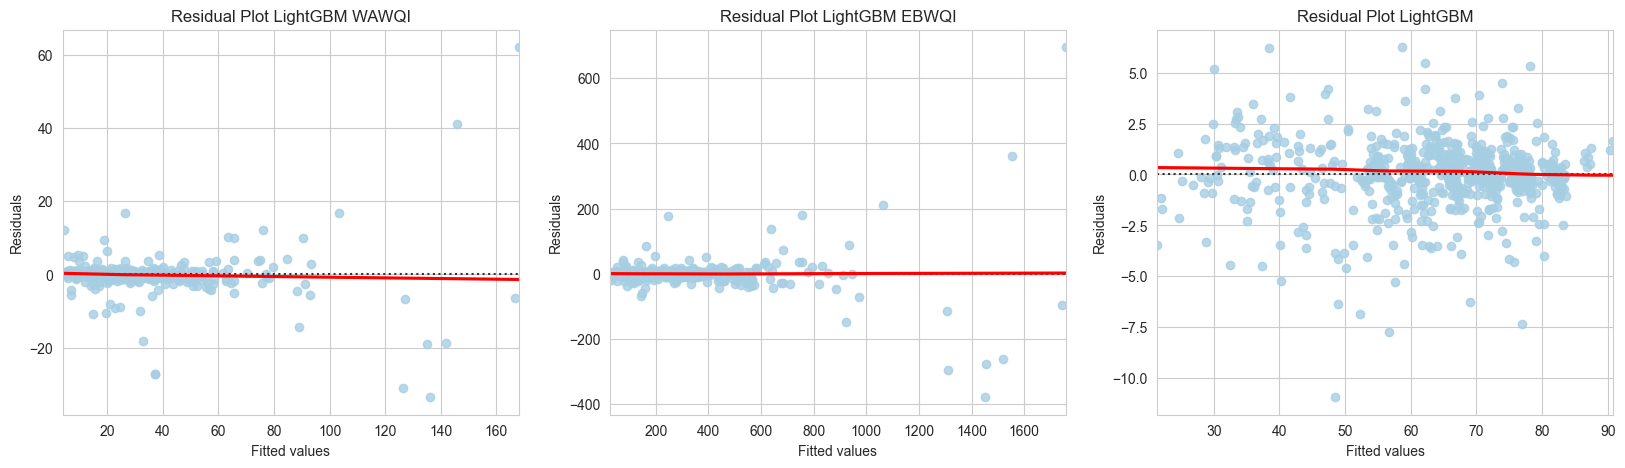

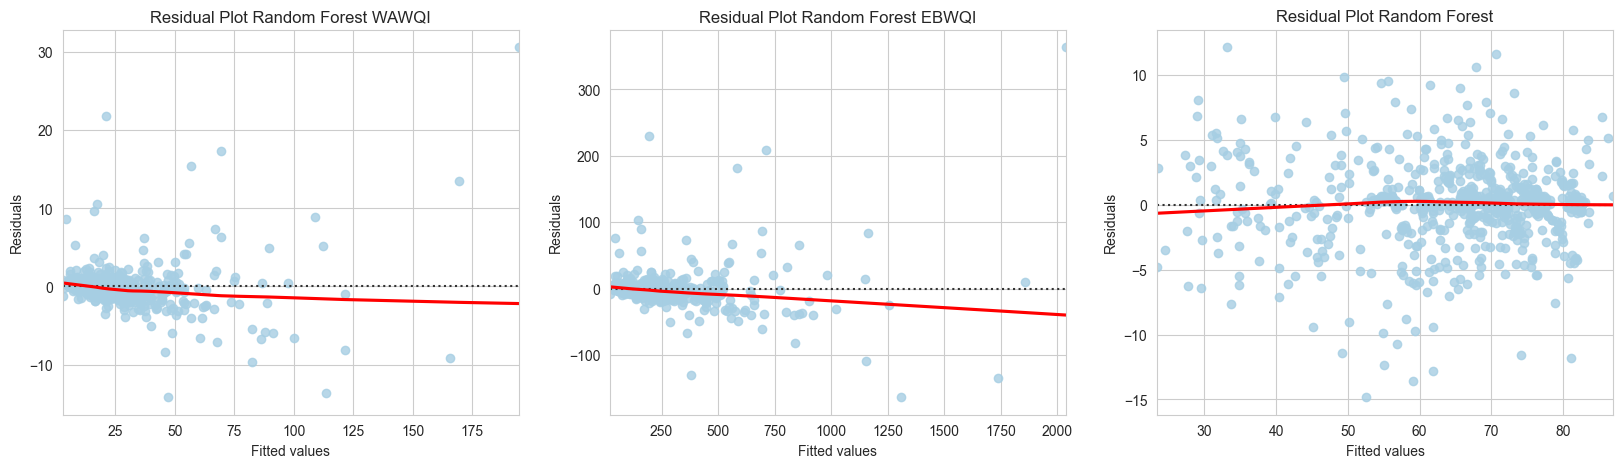

In [27]:
for model in ['Linear Regression', 'XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, target in zip(axes.flatten(), ['WAWQI', 'EBWQI', 'CCME-WQI']):
        resid_plot_df = regression_results_df[(regression_results_df['Model'] == model) & (regression_results_df['Metric'] == 'R2') & (regression_results_df['Target'] == target)]
        resid_plot_df['residuals'] = resid_plot_df['y_test'] - resid_plot_df['y_pred']
        sns.residplot(x=resid_plot_df['y_pred'].values[0], y=resid_plot_df['residuals'].values[0].values, lowess=True, line_kws={'color': 'red'}, ax=ax)
        ax.set_xlabel("Fitted values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot {model} {resid_plot_df['Target'].values[0]}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {model}")

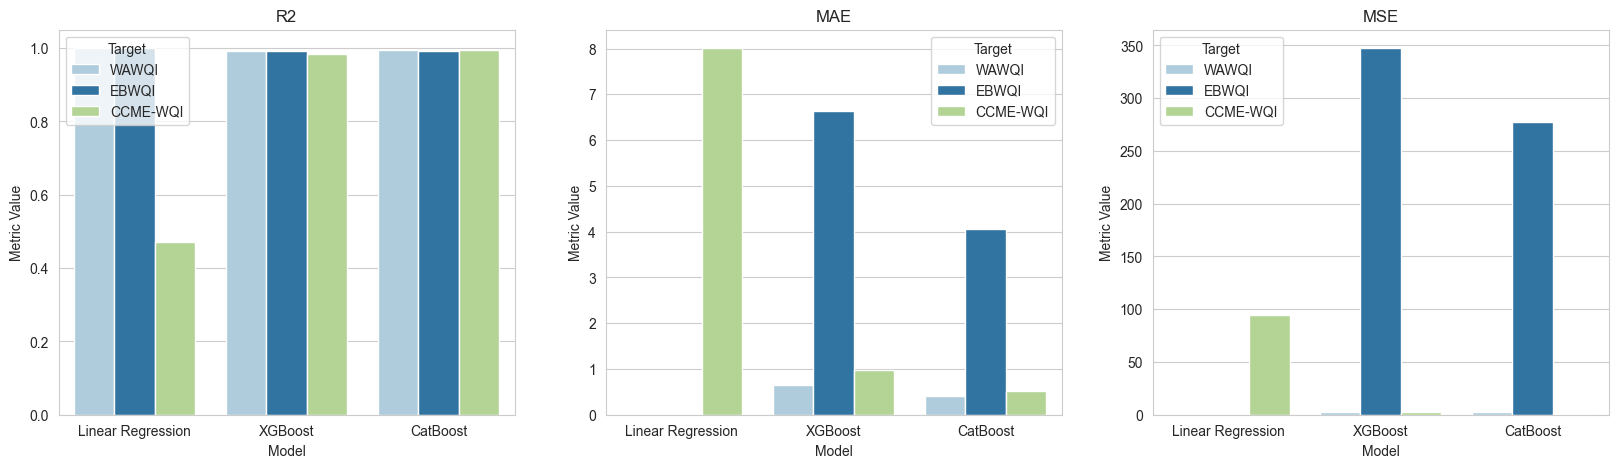

In [28]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['R2','MAE','MSE']:
        regression_results_df_tmp = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost'])) & (regression_results_df['Metric'] == metric)]
        sns.barplot(data=regression_results_df_tmp, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

## :sparkles: Best Models:
### Regression: CatBoost

# :sparkles: Hyperparameter Tuning

In [29]:
X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

# Regression
y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

# Train test split
X_train_reg, X_test_reg, y1_train_reg, y1_test_reg, y2_train_reg, y2_test_reg, y3_train_reg, y3_test_reg = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

In [30]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [31]:
from functools import partial

def optimize_catboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(catboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_xgboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(xgboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_randomforest():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(optimize_randomforest, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

In [32]:
from functools import partial
import optuna
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

def catboost_objective(trial, X_train, y_train, X_test, y_test):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other hyperparameters here
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def xgboost_objective(trial, X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        # Add other hyperparameters here
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def randomforest_objective(trial, X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        # Add other hyperparameters here
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def optimize_catboost(X_train, y_train, X_test, y_test):
    study_regressor = optuna.create_study(direction='minimize')
    objective_with_args = partial(catboost_objective, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study_regressor.optimize(objective_with_args, n_trials=10)
    return study_regressor.best_params

def optimize_xgboost(X_train, y_train, X_test, y_test):
    study_regressor = optuna.create_study(direction='minimize')
    objective_with_args = partial(xgboost_objective, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study_regressor.optimize(objective_with_args, n_trials=10)
    return study_regressor.best_params

def optimize_randomforest(X_train, y_train, X_test, y_test):
    study_regressor = optuna.create_study(direction='minimize')
    objective_with_args = partial(randomforest_objective, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study_regressor.optimize(objective_with_args, n_trials=10)
    return study_regressor.best_params

# Example usage
best_params_catboost_y1 = optimize_catboost(X_train_reg, y1_train_reg, X_test_reg, y1_test_reg)
best_params_xgboost_y1 = optimize_xgboost(X_train_reg, y1_train_reg, X_test_reg, y1_test_reg)
best_params_randomforest_y1 = optimize_randomforest(X_train_reg, y1_train_reg, X_test_reg, y1_test_reg)

best_params_catboost_y2 = optimize_catboost(X_train_reg, y2_train_reg, X_test_reg, y2_test_reg)
best_params_xgboost_y2 = optimize_xgboost(X_train_reg, y2_train_reg, X_test_reg, y2_test_reg)
best_params_randomforest_y2 = optimize_randomforest(X_train_reg, y2_train_reg, X_test_reg, y2_test_reg)

best_params_catboost_y3 = optimize_catboost(X_train_reg, y3_train_reg, X_test_reg, y3_test_reg)
best_params_xgboost_y3 = optimize_xgboost(X_train_reg, y3_train_reg, X_test_reg, y3_test_reg)
best_params_randomforest_y3 = optimize_randomforest(X_train_reg, y3_train_reg, X_test_reg, y3_test_reg)

print("Best Parameters for CatBoost Regressor - Y1:", best_params_catboost_y1)
print("Best Parameters for XGBoost Regressor - Y1:", best_params_xgboost_y1)
print("Best Parameters for RandomForest Regressor - Y1:", best_params_randomforest_y1)

print("Best Parameters for CatBoost Regressor - Y2:", best_params_catboost_y2)
print("Best Parameters for XGBoost Regressor - Y2:", best_params_xgboost_y2)
print("Best Parameters for RandomForest Regressor - Y2:", best_params_randomforest_y2)

print("Best Parameters for CatBoost Regressor - Y3:", best_params_catboost_y3)
print("Best Parameters for XGBoost Regressor - Y3:", best_params_xgboost_y3)
print("Best Parameters for RandomForest Regressor - Y3:", best_params_randomforest_y3)

[I 2024-05-12 18:20:10,202] A new study created in memory with name: no-name-1eb35ffc-982c-457f-8fe8-6f220eedb133


[I 2024-05-12 18:20:13,337] Trial 0 finished with value: 48.38851129097168 and parameters: {'iterations': 941, 'learning_rate': 0.0017755619932782391}. Best is trial 0 with value: 48.38851129097168.
[I 2024-05-12 18:20:15,730] Trial 1 finished with value: 10.816984879613285 and parameters: {'iterations': 584, 'learning_rate': 0.011224768983671913}. Best is trial 1 with value: 10.816984879613285.
[I 2024-05-12 18:20:19,533] Trial 2 finished with value: 5.668026280542874 and parameters: {'iterations': 859, 'learning_rate': 0.011941438131796997}. Best is trial 2 with value: 5.668026280542874.
[I 2024-05-12 18:20:22,653] Trial 3 finished with value: 16.739488562663333 and parameters: {'iterations': 823, 'learning_rate': 0.005957974598951495}. Best is trial 2 with value: 5.668026280542874.
[I 2024-05-12 18:20:25,658] Trial 4 finished with value: 2.1954958765835233 and parameters: {'iterations': 712, 'learning_rate': 0.0820475562106378}. Best is trial 4 with value: 2.1954958765835233.
[I 202

Best Parameters for CatBoost Regressor - Y1: {'iterations': 712, 'learning_rate': 0.0820475562106378}
Best Parameters for XGBoost Regressor - Y1: {'n_estimators': 469, 'learning_rate': 0.05515498553126712}
Best Parameters for RandomForest Regressor - Y1: {'n_estimators': 358, 'max_depth': 7}
Best Parameters for CatBoost Regressor - Y2: {'iterations': 473, 'learning_rate': 0.043825481658241974}
Best Parameters for XGBoost Regressor - Y2: {'n_estimators': 877, 'learning_rate': 0.009933460547316754}
Best Parameters for RandomForest Regressor - Y2: {'n_estimators': 800, 'max_depth': 10}
Best Parameters for CatBoost Regressor - Y3: {'iterations': 909, 'learning_rate': 0.021597226315224424}
Best Parameters for XGBoost Regressor - Y3: {'n_estimators': 756, 'learning_rate': 0.039096873760810495}
Best Parameters for RandomForest Regressor - Y3: {'n_estimators': 156, 'max_depth': 9}


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the ML models with their best parameters
catboost_model_y1 = CatBoostRegressor(**best_params_catboost_y1, verbose=0)
xgboost_model_y1 = XGBRegressor(**best_params_xgboost_y1)
randomforest_model_y1 = RandomForestRegressor(**best_params_randomforest_y1)

catboost_model_y2 = CatBoostRegressor(**best_params_catboost_y2, verbose=0)
xgboost_model_y2 = XGBRegressor(**best_params_xgboost_y2)
randomforest_model_y2 = RandomForestRegressor(**best_params_randomforest_y2)

catboost_model_y3 = CatBoostRegressor(**best_params_catboost_y3, verbose=0)
xgboost_model_y3 = XGBRegressor(**best_params_xgboost_y3)
randomforest_model_y3 = RandomForestRegressor(**best_params_randomforest_y3)

# Fit the models
catboost_model_y1.fit(X_train_reg, y1_train_reg)
xgboost_model_y1.fit(X_train_reg, y1_train_reg)
randomforest_model_y1.fit(X_train_reg, y1_train_reg)

catboost_model_y2.fit(X_train_reg, y2_train_reg)
xgboost_model_y2.fit(X_train_reg, y2_train_reg)
randomforest_model_y2.fit(X_train_reg, y2_train_reg)

catboost_model_y3.fit(X_train_reg, y3_train_reg)
xgboost_model_y3.fit(X_train_reg, y3_train_reg)
randomforest_model_y3.fit(X_train_reg, y3_train_reg)

# Predictions
y_pred_catboost_y1 = catboost_model_y1.predict(X_test_reg)
y_pred_xgboost_y1 = xgboost_model_y1.predict(X_test_reg)
y_pred_randomforest_y1 = randomforest_model_y1.predict(X_test_reg)

y_pred_catboost_y2 = catboost_model_y2.predict(X_test_reg)
y_pred_xgboost_y2 = xgboost_model_y2.predict(X_test_reg)
y_pred_randomforest_y2 = randomforest_model_y2.predict(X_test_reg)

y_pred_catboost_y3 = catboost_model_y3.predict(X_test_reg)
y_pred_xgboost_y3 = xgboost_model_y3.predict(X_test_reg)
y_pred_randomforest_y3 = randomforest_model_y3.predict(X_test_reg)

# Calculate RMSE and R2 score
def calculate_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rmse_catboost_y1, r2_catboost_y1 = calculate_metrics(y1_test_reg, y_pred_catboost_y1)
rmse_xgboost_y1, r2_xgboost_y1 = calculate_metrics(y1_test_reg, y_pred_xgboost_y1)
rmse_randomforest_y1, r2_randomforest_y1 = calculate_metrics(y1_test_reg, y_pred_randomforest_y1)

rmse_catboost_y2, r2_catboost_y2 = calculate_metrics(y2_test_reg, y_pred_catboost_y2)
rmse_xgboost_y2, r2_xgboost_y2 = calculate_metrics(y2_test_reg, y_pred_xgboost_y2)
rmse_randomforest_y2, r2_randomforest_y2 = calculate_metrics(y2_test_reg, y_pred_randomforest_y2)

rmse_catboost_y3, r2_catboost_y3 = calculate_metrics(y3_test_reg, y_pred_catboost_y3)
rmse_xgboost_y3, r2_xgboost_y3 = calculate_metrics(y3_test_reg, y_pred_xgboost_y3)
rmse_randomforest_y3, r2_randomforest_y3 = calculate_metrics(y3_test_reg, y_pred_randomforest_y3)

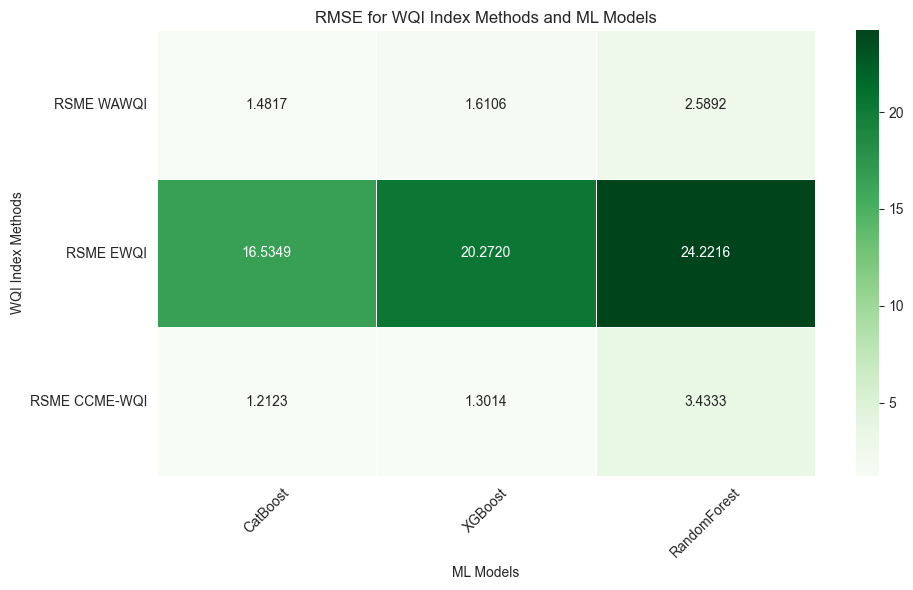

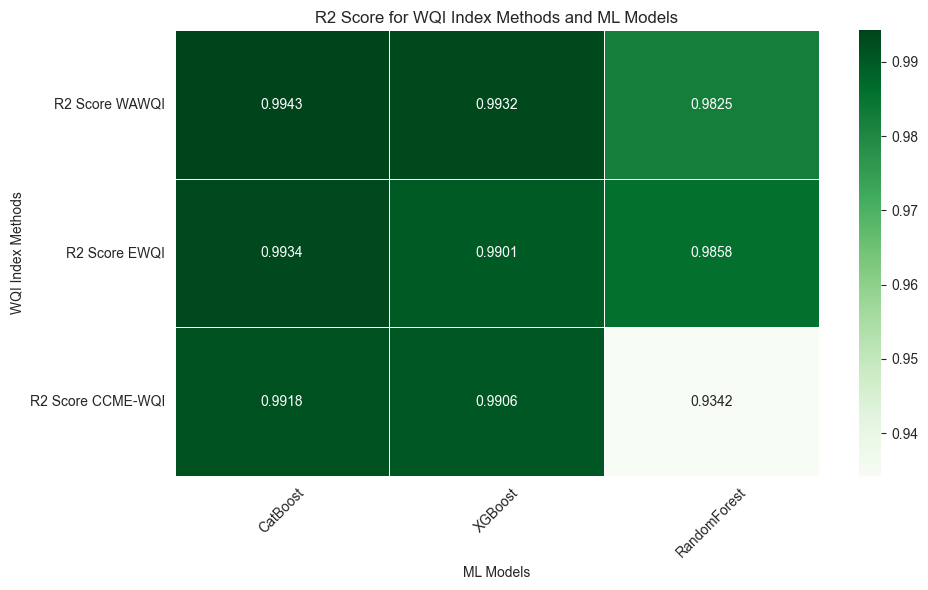

In [40]:
# Create a DataFrame with the results
data = {
    'Model': ['CatBoost', 'XGBoost', 'RandomForest'],
    'RSME WAWQI': [rmse_catboost_y1, rmse_xgboost_y1, rmse_randomforest_y1],
    'R2 Score WAWQI': [r2_catboost_y1, r2_xgboost_y1, r2_randomforest_y1],
    'RSME EWQI': [rmse_catboost_y2, rmse_xgboost_y2, rmse_randomforest_y2],
    'R2 Score EWQI': [r2_catboost_y2, r2_xgboost_y2, r2_randomforest_y2],
    'RSME CCME-WQI': [rmse_catboost_y3, rmse_xgboost_y3, rmse_randomforest_y3],
    'R2 Score CCME-WQI': [r2_catboost_y3, r2_xgboost_y3, r2_randomforest_y3]
}

results_df = pd.DataFrame(data)

# Plot RMSE values
plt.figure(figsize=(10, 6))
sns.heatmap(results_df[['Model', 'RSME WAWQI', 'RSME EWQI', 'RSME CCME-WQI']].set_index('Model').T, cmap='Greens', annot=True, fmt=".4f", linewidths=.5)
plt.title("RMSE for WQI Index Methods and ML Models")
plt.xlabel("ML Models")
plt.ylabel("WQI Index Methods")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot R2 score values
plt.figure(figsize=(10, 6))
sns.heatmap(results_df[['Model', 'R2 Score WAWQI', 'R2 Score EWQI', 'R2 Score CCME-WQI']].set_index('Model').T, cmap='Greens', annot=True, fmt=".4f", linewidths=.5)
plt.title("R2 Score for WQI Index Methods and ML Models")
plt.xlabel("ML Models")
plt.ylabel("WQI Index Methods")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Fit the models again to get feature importances
catboost_model_y1.fit(X_train_reg, y1_train_reg)
xgboost_model_y1.fit(X_train_reg, y1_train_reg)
randomforest_model_y1.fit(X_train_reg, y1_train_reg)

catboost_model_y2.fit(X_train_reg, y2_train_reg)
xgboost_model_y2.fit(X_train_reg, y2_train_reg)
randomforest_model_y2.fit(X_train_reg, y2_train_reg)

catboost_model_y3.fit(X_train_reg, y3_train_reg)
xgboost_model_y3.fit(X_train_reg, y3_train_reg)
randomforest_model_y3.fit(X_train_reg, y3_train_reg)

# Get feature importances
feature_importance_catboost_y1 = catboost_model_y1.get_feature_importance()
feature_importance_xgboost_y1 = xgboost_model_y1.feature_importances_
feature_importance_randomforest_y1 = randomforest_model_y1.feature_importances_

feature_importance_catboost_y2 = catboost_model_y2.get_feature_importance()
feature_importance_xgboost_y2 = xgboost_model_y2.feature_importances_
feature_importance_randomforest_y2 = randomforest_model_y2.feature_importances_

feature_importance_catboost_y3 = catboost_model_y3.get_feature_importance()
feature_importance_xgboost_y3 = xgboost_model_y3.feature_importances_
feature_importance_randomforest_y3 = randomforest_model_y3.feature_importances_

# Create a DataFrame for feature importances
feature_importance_data = {
    'Feature': X_train_reg.columns,
    'CatBoost Y1': feature_importance_catboost_y1,
    'XGBoost Y1': feature_importance_xgboost_y1,
    'RandomForest Y1': feature_importance_randomforest_y1,
    'CatBoost Y2': feature_importance_catboost_y2,
    'XGBoost Y2': feature_importance_xgboost_y2,
    'RandomForest Y2': feature_importance_randomforest_y2,
    'CatBoost Y3': feature_importance_catboost_y3,
    'XGBoost Y3': feature_importance_xgboost_y3,
    'RandomForest Y3': feature_importance_randomforest_y3,
}

feature_importance_df = pd.DataFrame(feature_importance_data)

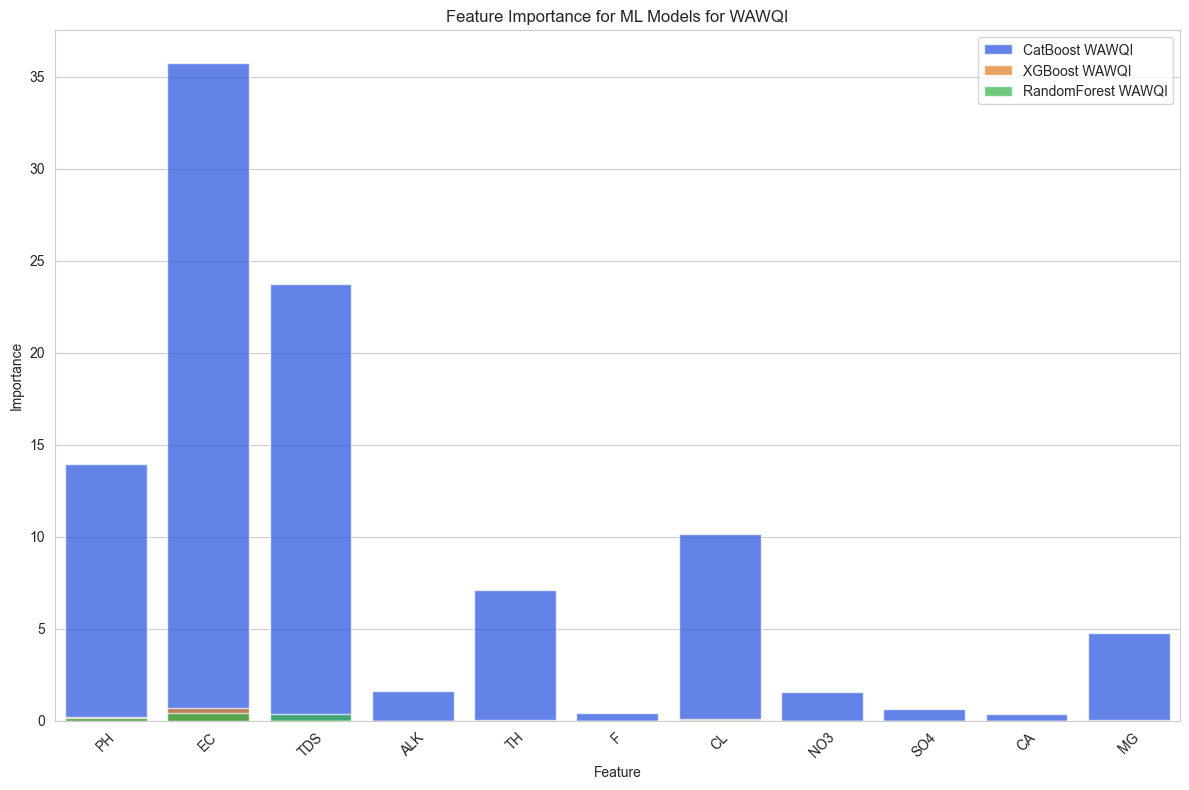

In [52]:


# Plot feature importances
plt.figure(figsize=(12, 8))
sns.set_palette('bright')
sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y1', alpha=0.7, label='CatBoost WAWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y1',alpha=0.7, label='XGBoost WAWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y1', alpha=0.7, label='RandomForest WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y2', color='cyan', alpha=0.7, label='CatBoost EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y2', color='orange', alpha=0.7, label='XGBoost EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y2', color='purple', alpha=0.7, label='RandomForest EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y3', color='brown', alpha=0.7, label='CatBoost CCME-WQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y3', color='pink', alpha=0.7, label='XGBoost CCME-WQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y3', color='yellow', alpha=0.7, label='RandomForest CCME-WQI')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for ML Models for WAWQI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

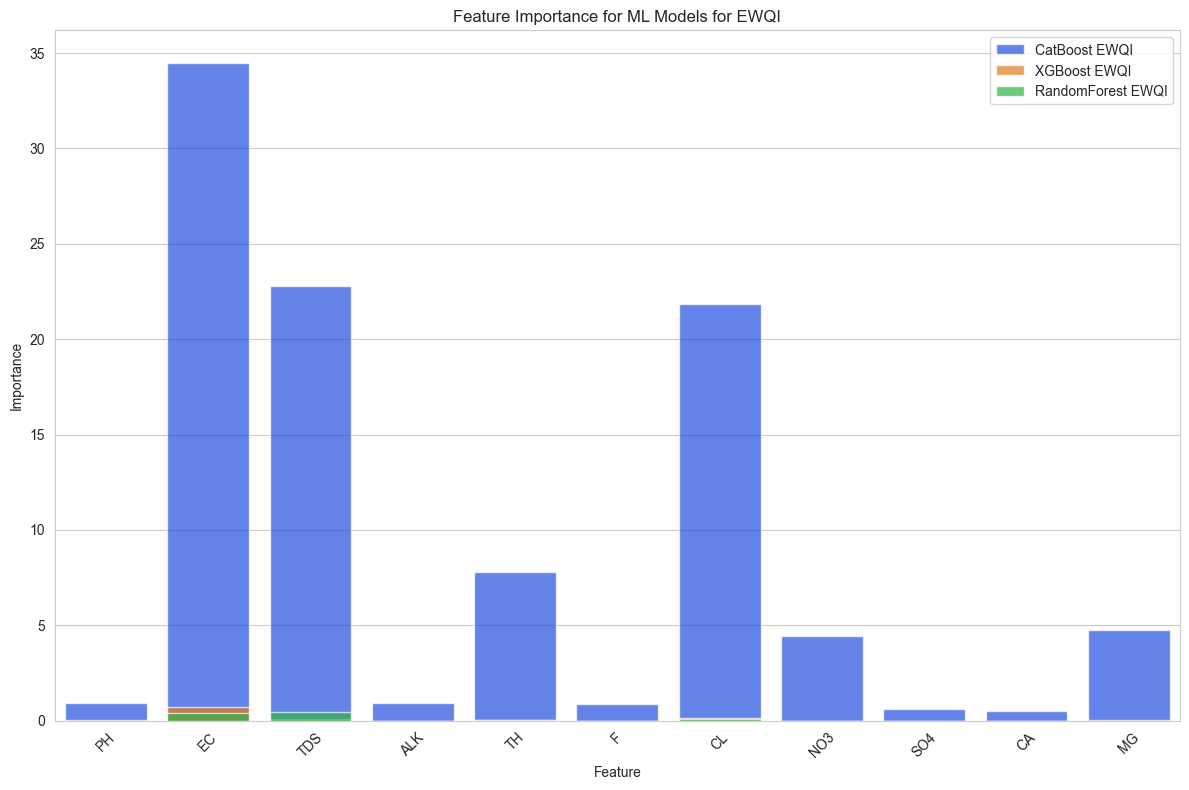

In [53]:
# Plot feature importances
plt.figure(figsize=(12, 8))
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y1', color='blue', alpha=0.7, label='CatBoost WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y1', color='red', alpha=0.7, label='XGBoost WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y1', color='green', alpha=0.7, label='RandomForest WAWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y2',alpha=0.7, label='CatBoost EWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y2', alpha=0.7, label='XGBoost EWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y2', alpha=0.7, label='RandomForest EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y3', color='brown', alpha=0.7, label='CatBoost CCME-WQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y3', color='pink', alpha=0.7, label='XGBoost CCME-WQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y3', color='yellow', alpha=0.7, label='RandomForest CCME-WQI')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for ML Models for EWQI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

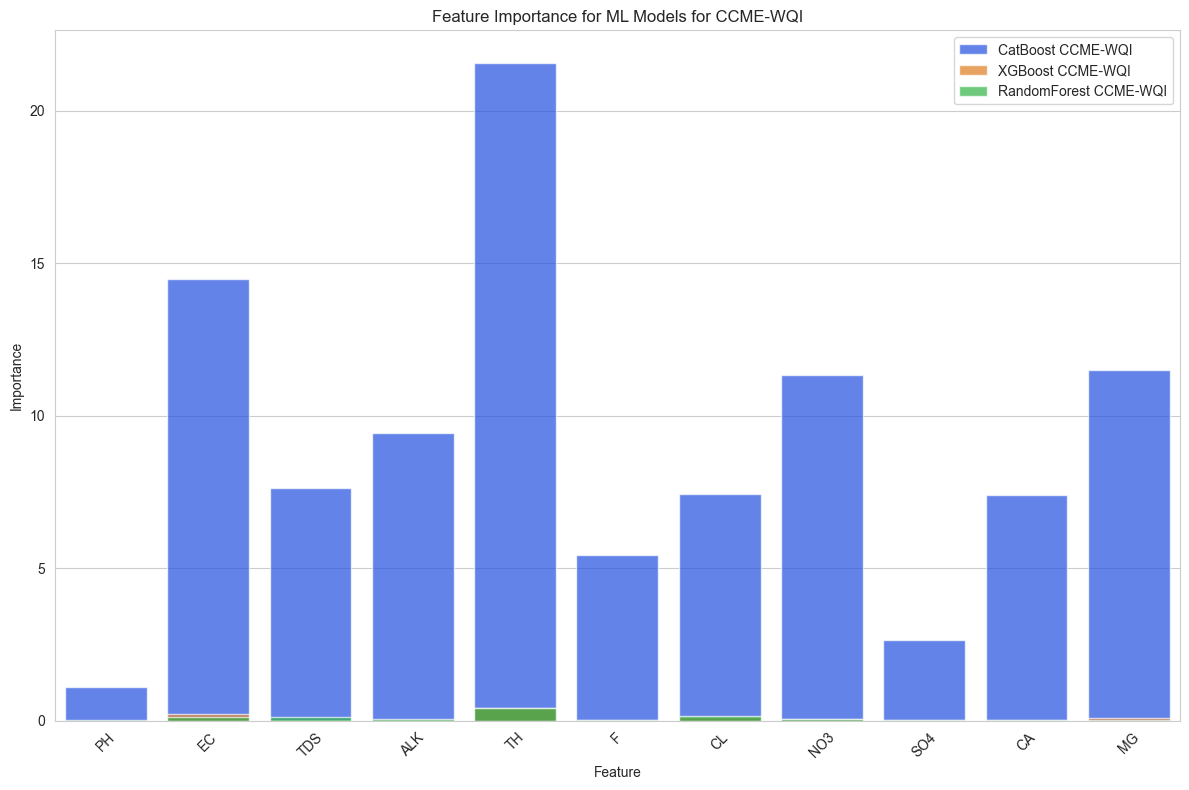

In [54]:
# Plot feature importances
plt.figure(figsize=(12, 8))
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y1', color='blue', alpha=0.7, label='CatBoost WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y1', color='red', alpha=0.7, label='XGBoost WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y1', color='green', alpha=0.7, label='RandomForest WAWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y2', color='cyan', alpha=0.7, label='CatBoost EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y2', color='orange', alpha=0.7, label='XGBoost EWQI')
# sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y2', color='purple', alpha=0.7, label='RandomForest EWQI')
sns.barplot(data=feature_importance_df, x='Feature', y='CatBoost Y3', alpha=0.7, label='CatBoost CCME-WQI')
sns.barplot(data=feature_importance_df, x='Feature', y='XGBoost Y3', alpha=0.7, label='XGBoost CCME-WQI')
sns.barplot(data=feature_importance_df, x='Feature', y='RandomForest Y3', alpha=0.7, label='RandomForest CCME-WQI')

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for ML Models for CCME-WQI')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()